**UNR - TUIA**

# Trabajo Prático N°: 2 - Aprendizaje Automático

### Integrantes:
*   Crenna, Giuliano. Legajo: C-7438/1.
*   Pace, Bruno. Legajo: P-5295/7.
*   Sancho Almenar, Mariano. Legajo: S-5778/9.

In [42]:
#Tratamiento de datos:
import numpy as np
import pandas as pd
import math

#Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocesado y modelado:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, SGDRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import random

from typing import Dict, List, Tuple
import os

#Configuración de warnings:
import warnings
warnings.filterwarnings('ignore')

In [26]:
DATASET_PATH: str = os.path.join(os.getcwd(), 'data', 'weatherAUS.csv')

# EDA

Se seleccionan 10 ciudades aleatorias.

In [92]:
df: pd.DataFrame = pd.read_csv(DATASET_PATH)

In [93]:
random.seed(42)
choosen_cities: List[str] = random.sample(df['Location'].unique().tolist(), k=10)

In [94]:
df: pd.DataFrame = df[df['Location'].isin(choosen_cities)].reset_index(drop = True) 

**Preprocesado:**
1. Convertimos la variable Date a tipo datetime.
2. Rellenamos los valores NA de las columnas numericas utilizando la media.

In [95]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [96]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].fillna(df[column].mean(), inplace=True)
    elif pd.api.types.is_object_dtype(df[column]):
        df[column].fillna('Desc', inplace=True)

### Distribuciones

Graficamos las siguientes distribuciones:
1. Temperaturas Mínimas
2. Temperaturas Máximas
3. Precipitaciones

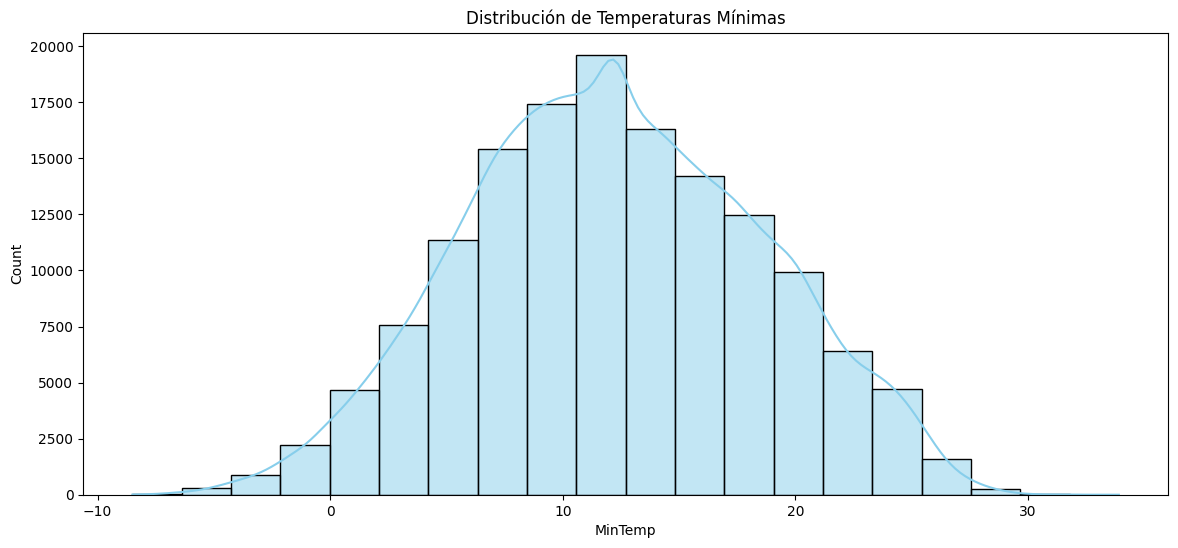

In [49]:
plt.figure(figsize=(14, 6))
sns.histplot(df['MinTemp'], bins=20, color='skyblue', kde=True)
plt.title("Distribución de Temperaturas Mínimas")
plt.show()

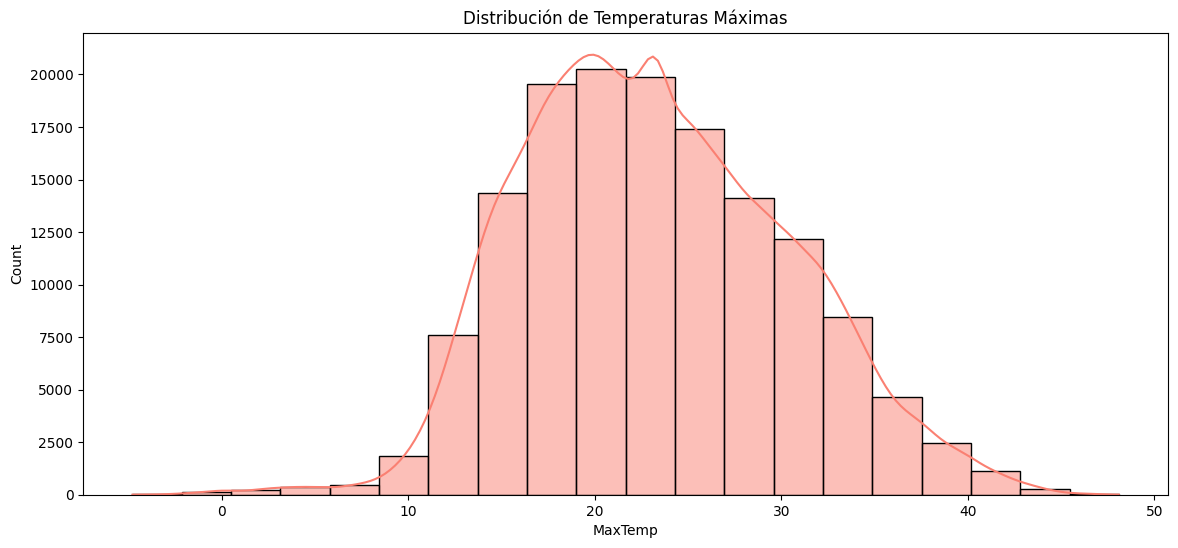

In [50]:
plt.figure(figsize=(14, 6))
sns.histplot(df['MaxTemp'], bins=20, color='salmon', kde=True)
plt.title("Distribución de Temperaturas Máximas")
plt.show()

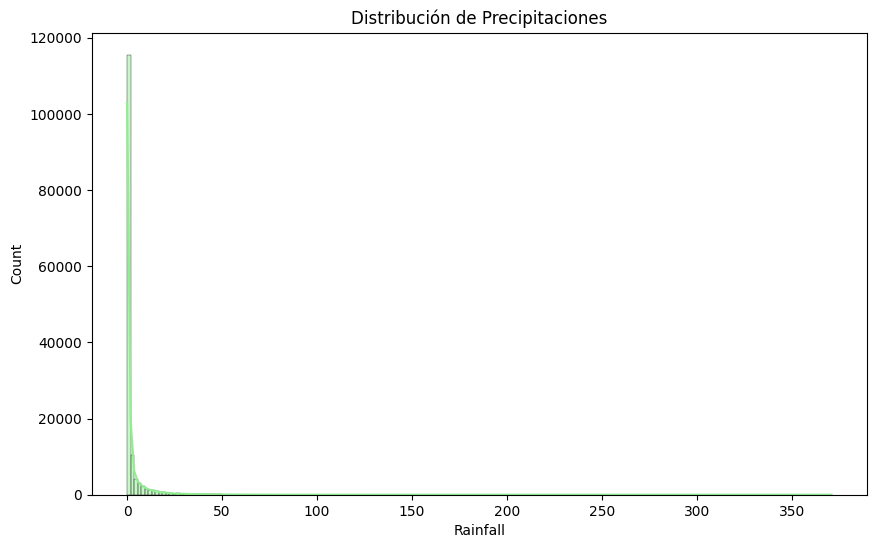

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rainfall'], bins=200, color='lightgreen', kde=True)
plt.title("Distribución de Precipitaciones")
plt.show()

### Matriz de correlación
Generamos la matriz de correlación, donde podemos lo siguiente:

**Correlaciones positivas altas:**
1. MaxTemp - MinTemp
2. Evaporation - MaxTemp
3. WinSpeed9am - WindGustSpeed
4. WinSpeed3am - WindGustSpeed
5. WinSpeed9am - WinSpeed3am
6. Evaporation - Temp9am
7. Evaporation - Temp3am
8. Humidity3pm - Humidity9pm
 
**Correlaciones negativas altas:**
1. Sunshine - Cloud9am
2. Sunshine - Cloud3am
3. Sunshine - Humidity9pm 
4. Sunshine - Humidity3pm

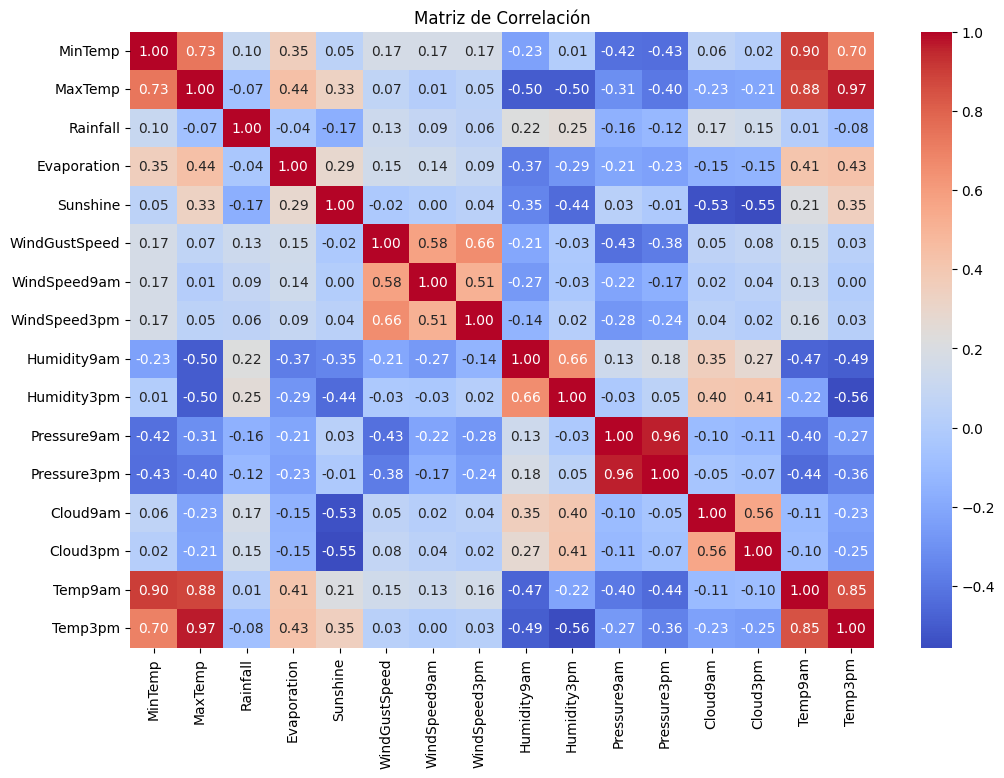

In [52]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### Análisis de desbalanceo
El dataset en la variable RainTomorrow está claramente desbalanceado, ya que el valor categórico Yes solo representa el 4.56% de los datos.

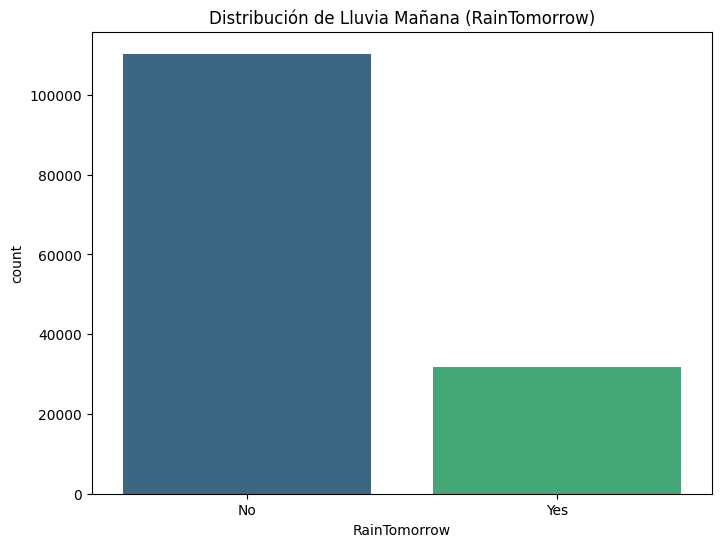

In [53]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RainTomorrow', data=df, palette='viridis')
plt.title("Distribución de Lluvia Mañana (RainTomorrow)")
plt.show()


In [54]:
float(df['RainTomorrow'].shape[0] / df['RainTomorrow'].value_counts()['Yes'])

4.5631646641779335

### Series temporales
Es importante observar cómo las temperaturas y precipitaciones varían con el tiempo.

Como podemos observar las series de tiempo de las temperaturas mínimas y máximas son estrictamente estacionales. Mientras que las precipitaciones no presentan estacionalidad.

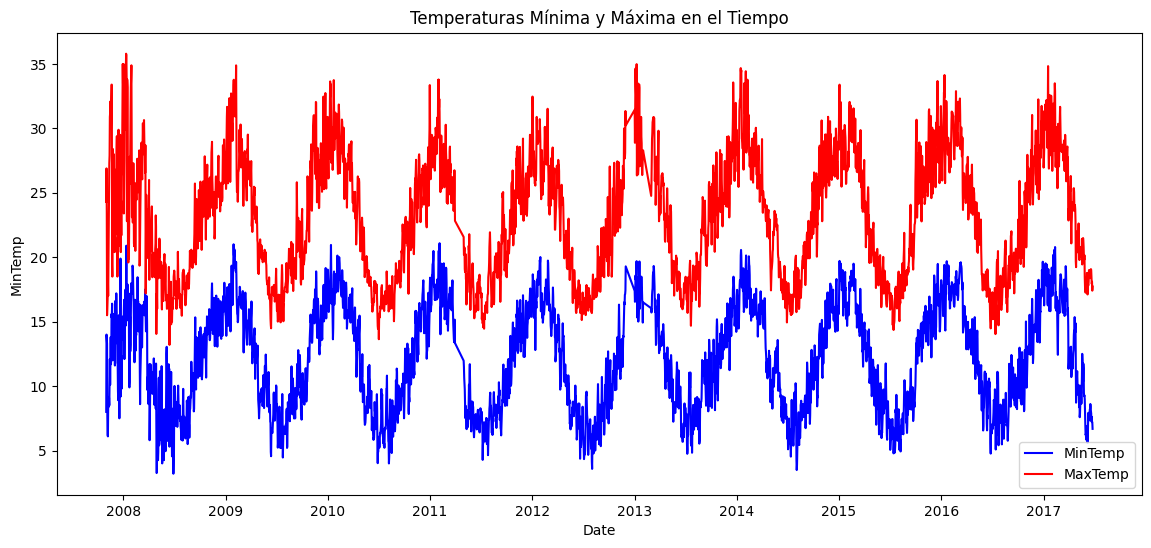

In [55]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='MinTemp', data=df, label='MinTemp', color='blue', ci=None)
sns.lineplot(x='Date', y='MaxTemp', data=df, label='MaxTemp', color='red', ci=None)
plt.title("Temperaturas Mínima y Máxima en el Tiempo")
plt.show()

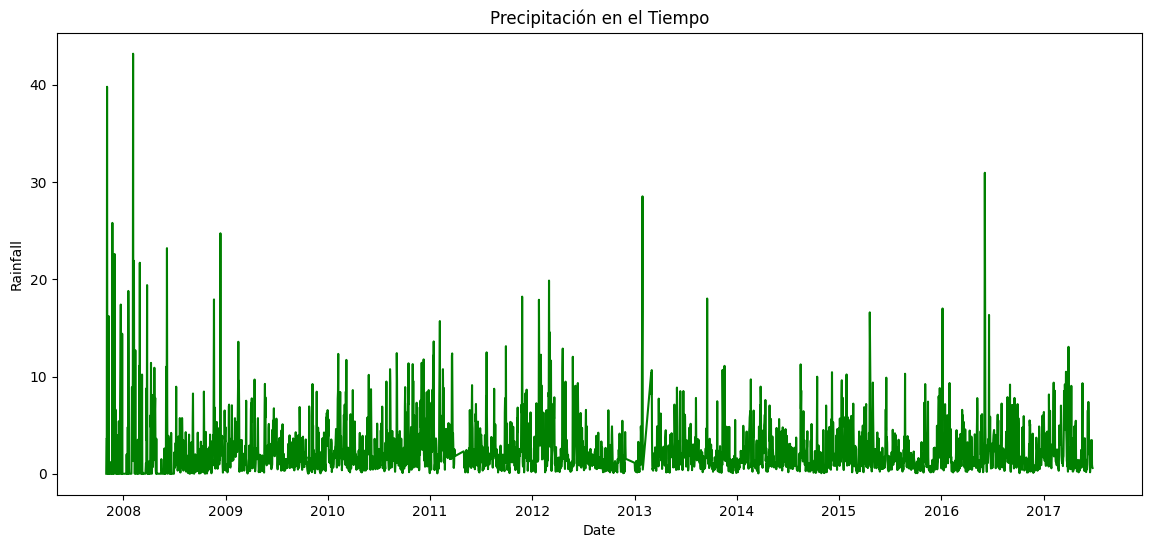

In [56]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='Rainfall', data=df, color='green', ci=None)
plt.title("Precipitación en el Tiempo")
plt.show()


## Lectura, selección de ciudades y analisis de variables

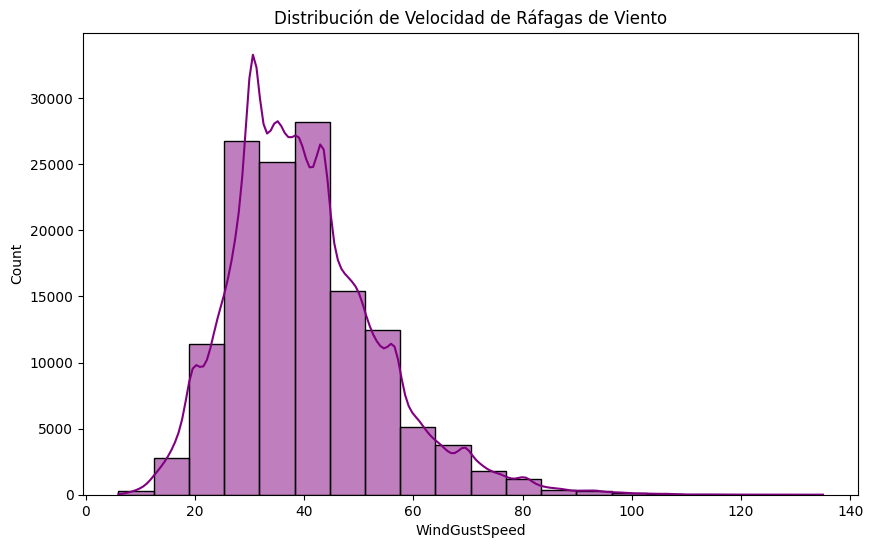

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df['WindGustSpeed'], bins=20, color='purple', kde=True)
plt.title("Distribución de Velocidad de Ráfagas de Viento")
plt.show()

Acá podemos ver que no existe un gran desbalanceo entre los valores categóricos de las direcciones del viento.

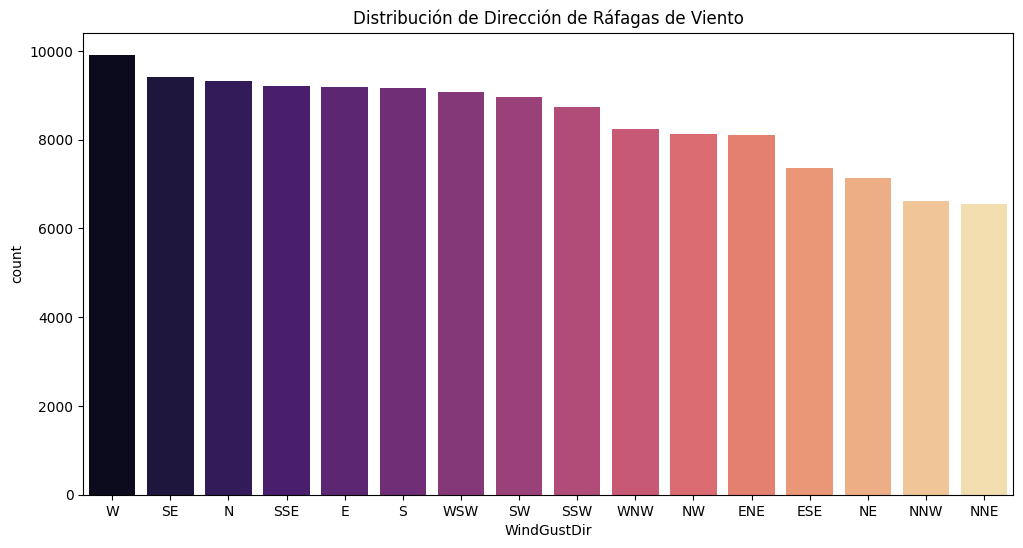

In [41]:
plt.figure(figsize=(12, 6))
sns.countplot(x='WindGustDir', data=df, palette="magma", order=df['WindGustDir'].value_counts().index)
plt.title("Distribución de Dirección de Ráfagas de Viento")
plt.show()

Se seleccionan 10 ciudades aleatorias de dataset para analizar


### Tipo de dato de las variables

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30818 entries, 0 to 30817
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           30818 non-null  datetime64[ns]
 1   Location       30818 non-null  object        
 2   MinTemp        30818 non-null  float64       
 3   MaxTemp        30818 non-null  float64       
 4   Rainfall       30818 non-null  float64       
 5   Evaporation    30818 non-null  float64       
 6   Sunshine       30818 non-null  float64       
 7   WindGustDir    30818 non-null  object        
 8   WindGustSpeed  30818 non-null  float64       
 9   WindDir9am     30818 non-null  object        
 10  WindDir3pm     30818 non-null  object        
 11  WindSpeed9am   30818 non-null  float64       
 12  WindSpeed3pm   30818 non-null  float64       
 13  Humidity9am    30818 non-null  float64       
 14  Humidity3pm    30818 non-null  float64       
 15  Pressure9am    3081

In [61]:
df[['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',  'RainToday', 'RainTomorrow']].sample(2)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
13947,2014-04-30,Penrith,SW,S,SSW,NaN,No
8095,2014-11-12,NorahHead,NNE,SSW,E,No,No


Se observa la presencia de ocho columnas categóricas, su análisis y procesamiento a continuacion.


### Date

Dado que 'Date' se encuentra con formato 'YYYY-MM-DD', se dividirá en 2 columnas distintas.

- **Year**: Será una variable categórica indicando el año, luego se codificará utilizando One-Hot Encoder.
- **Season**:  Indicará en qué temporada del año ocurrió la medición.

In [101]:
# OPCION 2
"""
Juntar mes y dia para que sea una columna numerica de 0 a 365, 
así hay un menor salto entre estaciones del año
el unico problema -> el salto de fin/comienzo de año

ANALIZAR HACER PROYECCIONES X E Y 
para mi (Mariano) probar este metodo, si sobra tiempo lo hacemos
""" 
# Lo comento porque se hace esta transformaciónn al principio df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

df['Day'] = df['Date'].dt.dayofyear

In [102]:
df[['Date', 'Year', 'Day']].sample(2)

,Date,Year,Day
1495,2013-05-04,2013,124
26962,2015-09-02,2015,245


In [103]:
df.drop(columns= 'Date', inplace=True)

In [104]:
def get_season(date: np.datetime64) -> str:
    Y = date.year
    if pd.Timestamp(f'{Y}-12-1') <= date or date < pd.Timestamp(f'{Y}-03-01'):
        return 'Verano'
    elif pd.Timestamp(f'{Y}-03-01') <= date < pd.Timestamp(f'{Y}-06-01'):
        return 'Otoño'
    elif pd.Timestamp(f'{Y}-06-01') <= date < pd.Timestamp(f'{Y}-09-01'):
        return 'Invierno'
    else:
        return 'Primavera'


### Mediciones del viento

Las columnas *WindGustDir*, *WindDir9am*, *WindDir3pm*, *WindSpeed3pm* indican la dirección del viento utilizando las direcciones cardinales.

Se transformarán dichas direcciones en las proyecciones que tienen sobre los ejes x e y.

In [84]:
def angle_to_xy(angle: float) -> Tuple[np.float64, np.float64]:
    """
    Función que recibe la dirección del viento en grados y la transformará en projecciones sobre el eje x e y, 
    obteniendo así dos valores numéricos por cada columna.
    """

    if math.isnan(angle):
        return (np.nan, np.nan)

    # Convertimos el ángulo a radianes
    angle_rad = math.radians(angle)


    x = math.sin(angle_rad)
    y = math.cos(angle_rad)

    return (x, y)

In [97]:
direction_angles: dict[str, float] = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
}

columnas_viento: List[str] = ['WindDir3pm','WindDir9am', 'WindGustDir']

for columna in columnas_viento:
    df[columna] = df[columna].map(direction_angles)

# Creamos las columnas con las projecciones x e y para los distintos vientos.
df[['WindDir3pm_x', 'WindDir3pm_y']] = df['WindDir3pm'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindDir9am_x', 'WindDir9am_y']] = df['WindDir9am'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

df[['WindGustDir_x', 'WindGustDir_y']] = df['WindGustDir'].apply(
    lambda angle: pd.Series(angle_to_xy(angle))
)

In [98]:
df.drop(columns=columnas_viento , inplace=True)


### Columnas categóricas Yes/No

Se remplazan por valores 1 y 0 

In [99]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [109]:
df[['Year', 'Day', 'Location', 'WindDir3pm_x', 'WindDir3pm_y', 'WindDir9am_x', 'WindDir9am_y','WindGustDir_x', 'WindGustDir_y' ,  'RainToday', 'RainTomorrow']].sample(3)

,Year,Day,Location,WindDir3pm_x,WindDir3pm_y,WindDir9am_x,WindDir9am_y,WindGustDir_x,WindGustDir_y,RainToday,RainTomorrow
4163,2012,59,Newcastle,-3.826834e-01,0.923880,NaN,NaN,NaN,NaN,0.0,0.0
29838,2014,293,Perth,-7.071068e-01,-0.707107,-0.382683,-0.92388,-0.923880,-0.382683,1.0,0.0
14793,2016,236,Penrith,1.224647e-16,-1.000000,0.382683,0.92388,-0.382683,-0.923880,1.0,0.0


### Location

Para la localidad, se remplaza su valor con su respectiva coordenada


In [110]:
chosen_cities_coordinates: Dict [str, Dict[str, float]] = {
    "Newcastle": {"latitude": -32.9282, "longitude": 151.7817},
    "BadgerysCreek": {"latitude": -33.8836, "longitude": 150.7386},
    "Penrith": {"latitude": -33.7532, "longitude": 150.6880},
    "Perth": {"latitude": -31.9505, "longitude": 115.8605},
    "Canberra": {"latitude": -35.2809, "longitude": 149.1300},
    "Wollongong": {"latitude": -34.4278, "longitude": 150.8931},
    "Nuriootpa": {"latitude": -34.4658, "longitude": 138.9784},
    "NorahHead": {"latitude": -33.2886, "longitude": 151.6154},
    "NorfolkIsland": {"latitude": -29.0408, "longitude": 167.9547},
    "MountGinini": {"latitude": -35.4622, "longitude": 148.9525}
}


In [111]:
coords_df: pd.DataFrame = pd.DataFrame.from_dict(chosen_cities_coordinates, orient='index') 
coords_df.reset_index(inplace=True) 
coords_df.rename(columns={'index':'Location'}, inplace=True) 
coords_df

,Location,latitude,longitude
0,Newcastle,-32.9282,151.7817
1,BadgerysCreek,-33.8836,150.7386
2,Penrith,-33.7532,150.6880
3,Perth,-31.9505,115.8605
4,Canberra,-35.2809,149.1300
5,Wollongong,-34.4278,150.8931
6,Nuriootpa,-34.4658,138.9784
7,NorahHead,-33.2886,151.6154
8,NorfolkIsland,-29.0408,167.9547
9,MountGinini,-35.4622,148.9525


In [112]:
df: pd.DataFrame = df.merge(coords_df, on='Location', how='left')
df: pd.DataFrame = df.drop(columns=['Location'])


## Division del conjunto

In [113]:
X: pd.DataFrame = df.drop(columns='RainTomorrow')
y: pd.DataFrame = df[['RainTomorrow']] #Variable a predecir

Separación test y train conforme a las convenciones del 80% para Train y 20% para test.

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


## Manejo de variables categóricas
Usaremos one-hot encoding para el manejo de la columna *Year*.

In [185]:
columnas_categoricas: List[str] = ['Year']

encoder: OneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

In [186]:
X_train_enc = encoder.fit_transform(X_train[columnas_categoricas])
X_test_enc = encoder.transform(X_test[columnas_categoricas])

In [187]:
X_train = pd.concat([X_train, X_train_enc], axis=1)
X_test = pd.concat([X_test, X_test_enc], axis=1)

In [188]:
X_train.drop(columns=columnas_categoricas, inplace=True)
X_test.drop(columns=columnas_categoricas, inplace=True)

In [189]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24654 entries, 2194 to 23654
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        24654 non-null  float64
 1   MaxTemp        24654 non-null  float64
 2   Rainfall       24654 non-null  float64
 3   Evaporation    24654 non-null  float64
 4   Sunshine       24654 non-null  float64
 5   WindGustSpeed  24654 non-null  float64
 6   WindSpeed9am   24654 non-null  float64
 7   WindSpeed3pm   24654 non-null  float64
 8   Humidity9am    24654 non-null  float64
 9   Humidity3pm    24654 non-null  float64
 10  Pressure9am    24654 non-null  float64
 11  Pressure3pm    24654 non-null  float64
 12  Cloud9am       24654 non-null  float64
 13  Cloud3pm       24654 non-null  float64
 14  Temp9am        24654 non-null  float64
 15  Temp3pm        24654 non-null  float64
 16  RainToday      24203 non-null  float64
 17  WindDir3pm_x   23032 non-null  float64
 18  WindDir3


## Manejo de valores faltantes

Se utiliza KNN Imputer para imputar los valores faltantes.

In [190]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24654 entries, 2194 to 23654
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RainTomorrow  24203 non-null  float64
dtypes: float64(1)
memory usage: 385.2 KB


In [191]:
y_train.isna().sum()

RainTomorrow    451
dtype: int64

Se observa que y_train tiene 24654 datos, de los cuales 451 son datos faltantes. 

Esto representa aproximadamente 1.8% del dataset. Por eso se decide dropearlos.

In [192]:
#reseto indice para no tener problema
X_train.reset_index(inplace=True)
y_train.reset_index(inplace=True)

#almaceno los indices que no son na
indices_validos: pd.Index = y_train.dropna().index

Filtro los mismos indices válidos en ambos df de Train

In [193]:
y_train: pd.Series = y_train.iloc[indices_validos]
X_train: pd.DataFrame = X_train.iloc[indices_validos]

In [194]:
y_train.isna().sum()

index           0
RainTomorrow    0
dtype: int64

Análisis duplicados en X_train. No se realiza con y_train ya que son 0 y 1 y daría duplicados.

In [195]:
X_train.duplicated().sum()

np.int64(0)

In [196]:
#Eliminación de columnas indices
X_train = X_train.drop(columns=['index'])
y_train = y_train.drop(columns=['index'])

In [199]:
knn = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)

y_test = pd.DataFrame(knn.fit_transform(y_test), columns=y_test.columns)
y_train = pd.DataFrame(knn.transform(y_train), columns=y_train.columns)


## Visulizaciones de distribuciones

In [200]:
columns: list[str] = X_train.columns.tolist()

In [201]:
columns_sin_anios: list[str] = []

for col in columns:
    if 'Year' not in col:
        columns_sin_anios.append(col)
    else:
        print(f'{col} not saved')


Year_2007 not saved
Year_2008 not saved
Year_2009 not saved
Year_2010 not saved
Year_2011 not saved
Year_2012 not saved
Year_2013 not saved
Year_2014 not saved
Year_2015 not saved
Year_2016 not saved
Year_2017 not saved


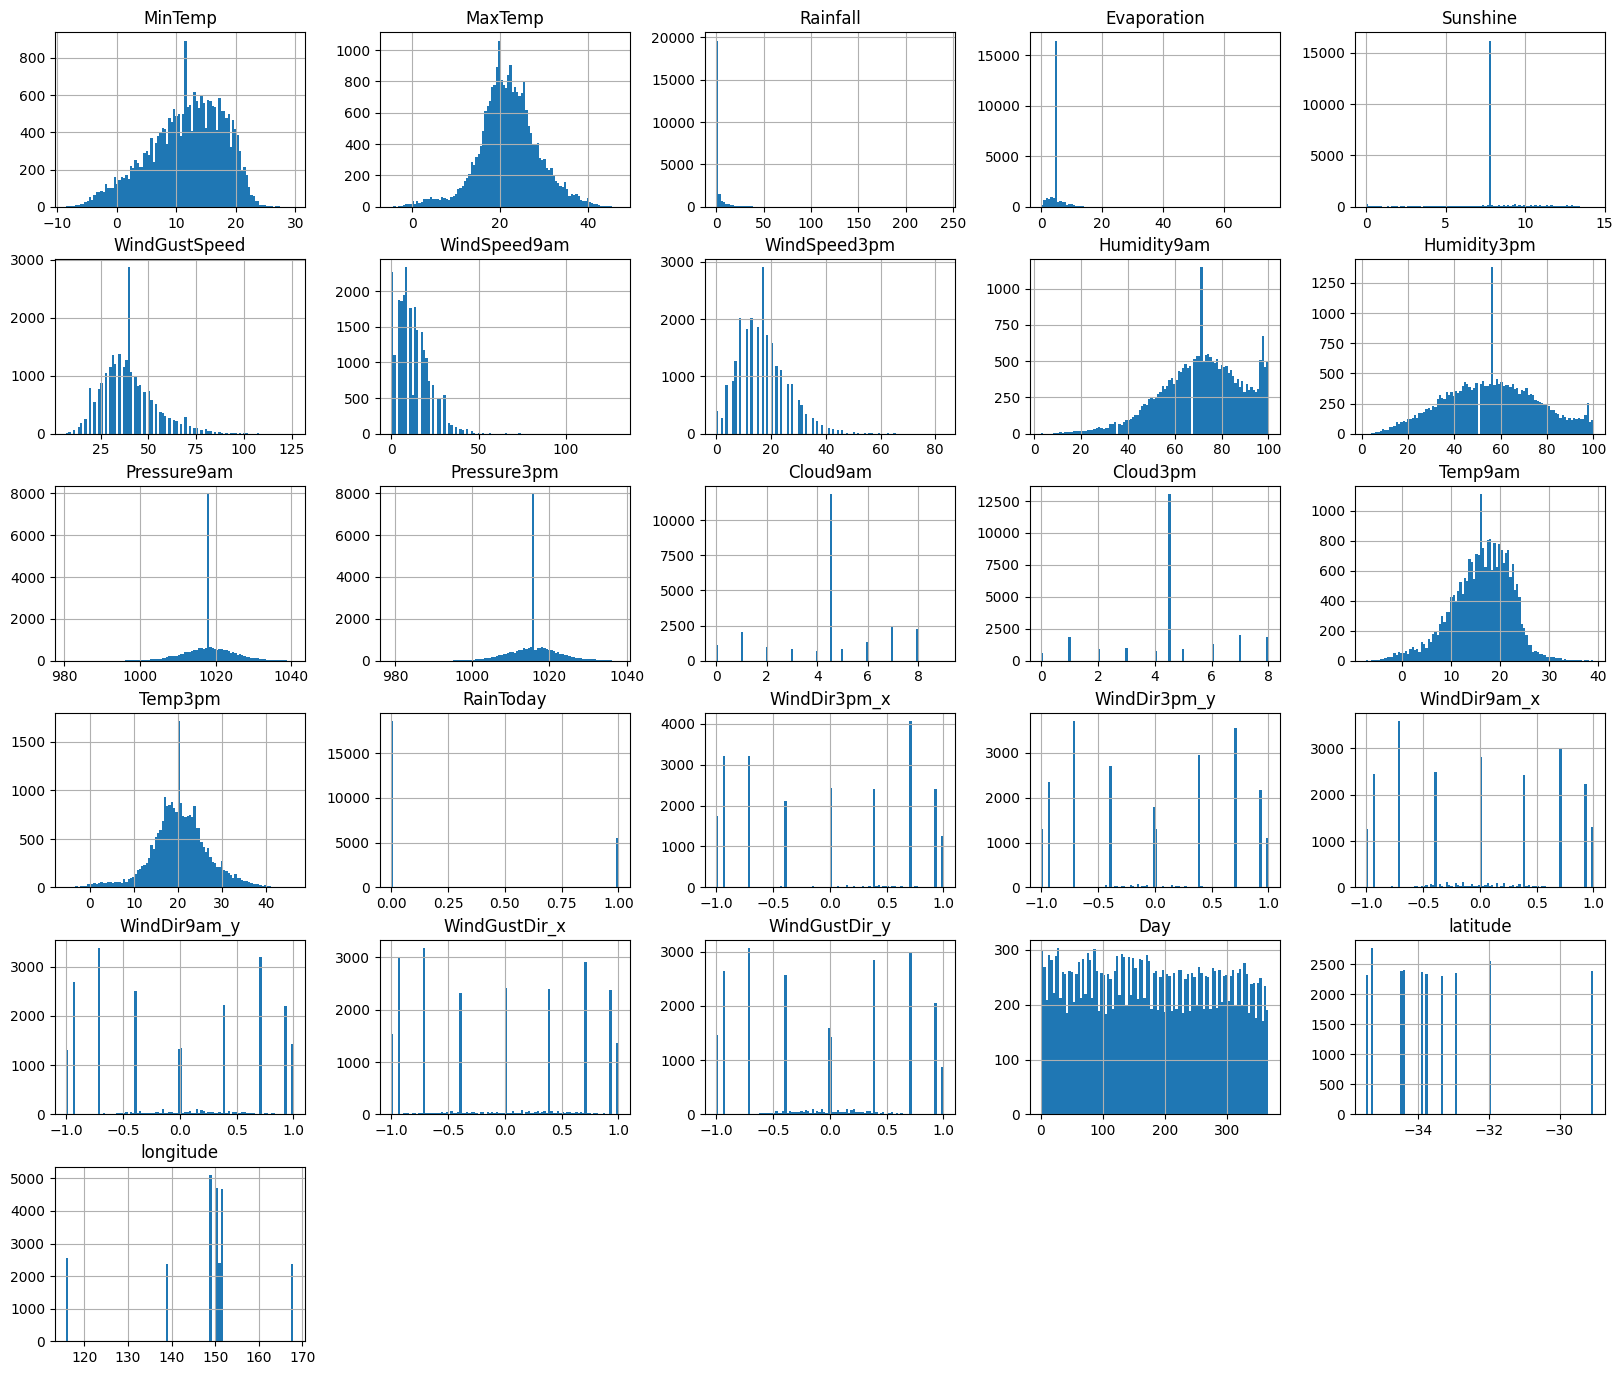

In [152]:
X_train[columns_sin_anios].hist(figsize= (20,17), bins=100)

plt.show()


## Estandarizado

In [202]:
scaler: StandardScaler = StandardScaler()

In [203]:
# Ajustar y transformar el conjunto de entrenamiento
X_train: pd.DataFrame = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test: pd.DataFrame = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


## Matriz de correlación

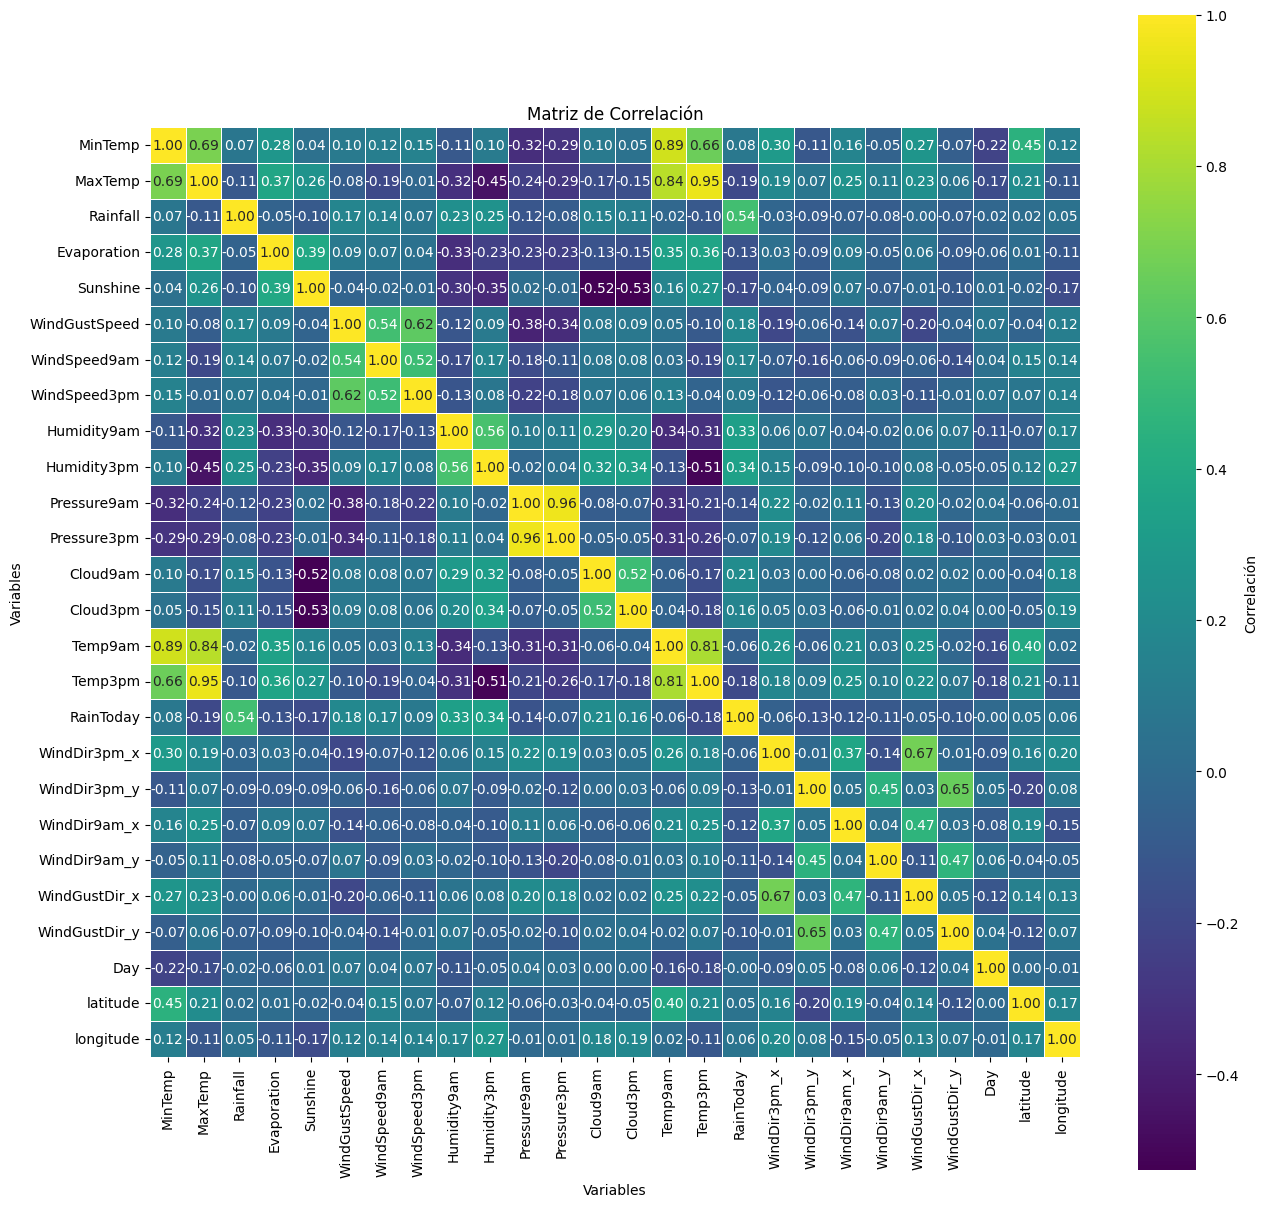

In [204]:
corr_matrix: np.ndarray = X_train[columns_sin_anios].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, 
            annot=True,  
            cmap='viridis',  
            cbar_kws={'label': 'Correlación'}, 
            square=True,  
            fmt='.2f', 
            linewidths=0.5,  
            linecolor='white')  

plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

plt.show()

In [205]:
numerical_float_columns: list[str] = X_train.select_dtypes(include=[np.number, 'float']).columns.to_list()

Graficamos solamentes las columnas numericas

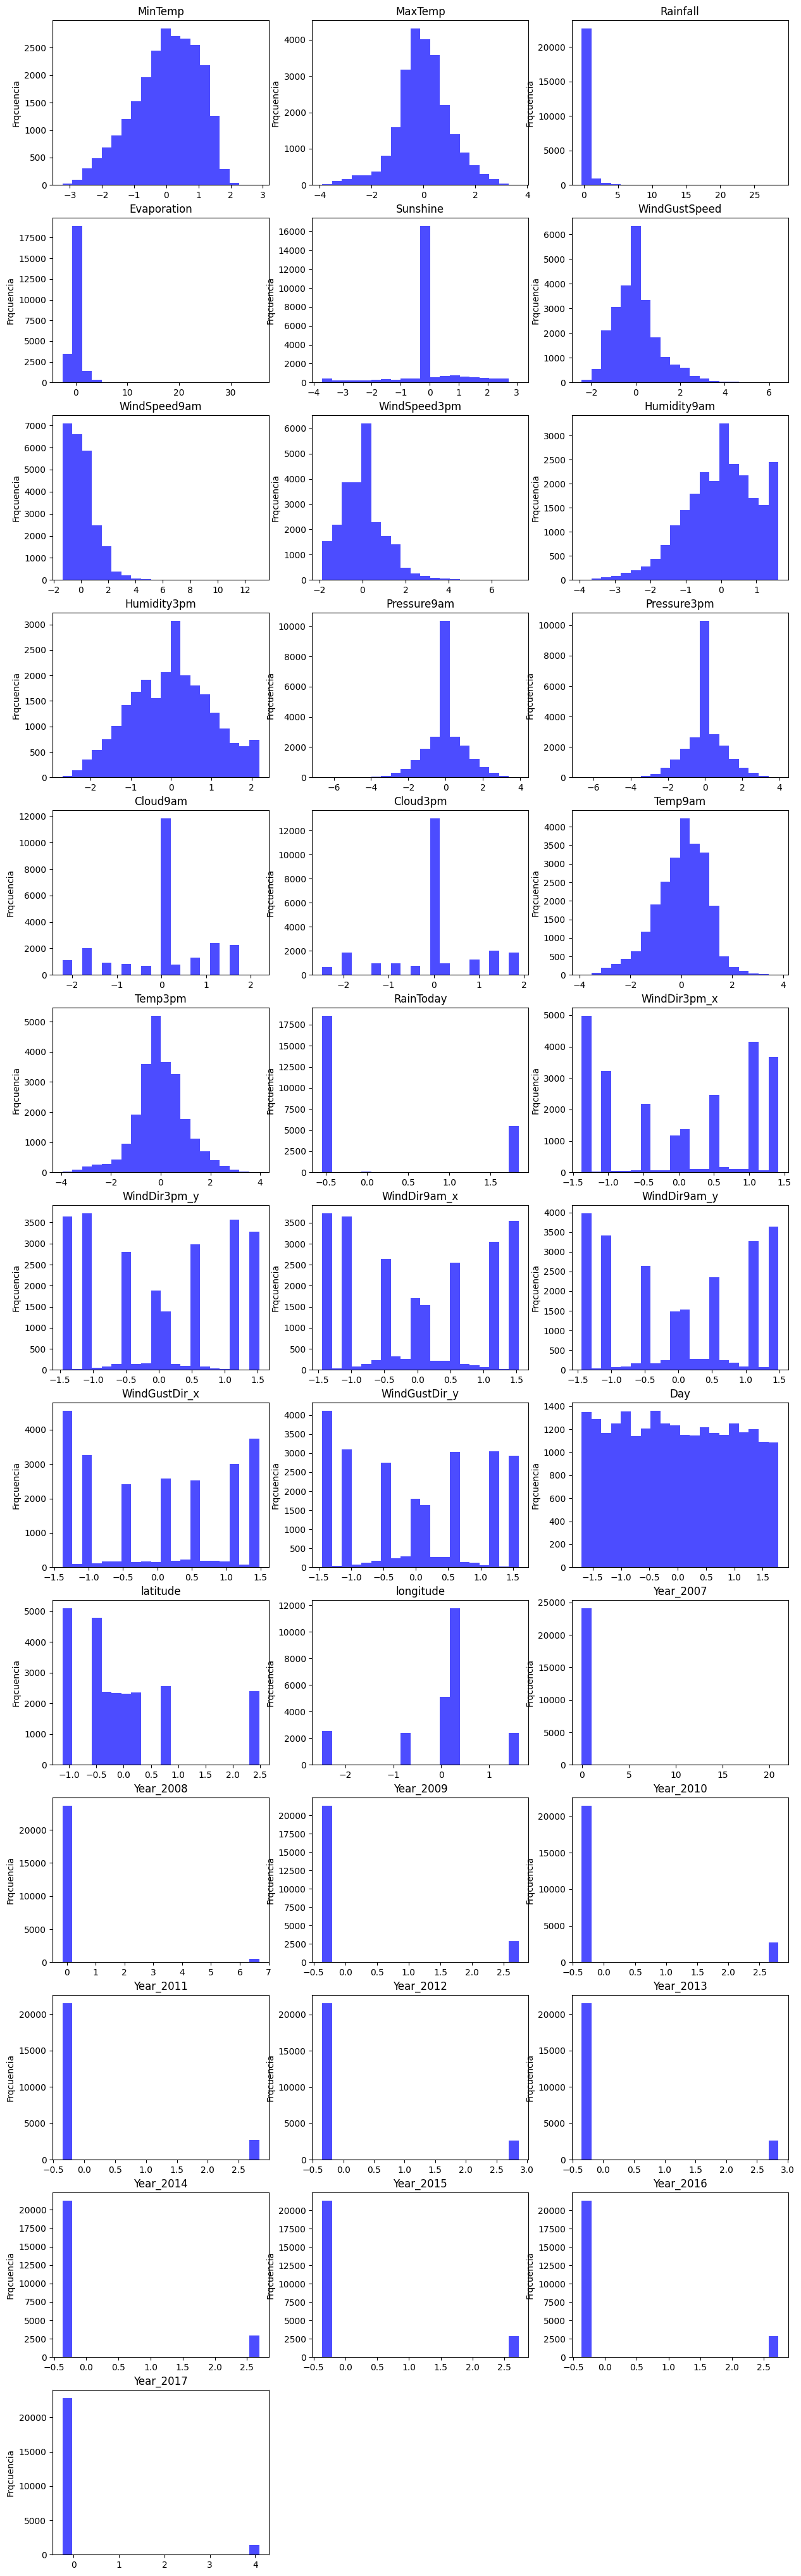

In [206]:
num_columns: int = 3 
num_rows: int = (len(numerical_float_columns) + num_columns - 1) // num_columns 

fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 4 * num_rows))

axes: np.ndarray = axes.flatten()

for ax, col in zip(axes, numerical_float_columns):
    ax.hist(X_train[col], bins=20, color='blue', alpha=0.7)
    ax.set_title(f'{col}')
    ax.set_ylabel('Frqcuencia')
    
for i in range(len(numerical_float_columns), len(axes)):
    fig.delaxes(axes[i])


## Implementación de modelos

Dado que el dataset se encuentra altamente desbalanceado, se descarta el uso de Accuracy como metrica.

Por lo que analizará el modelo en base a Precision, recall, F1

En una primera instancia, se analiza el modelo de regresión logistica 


### Regresión logística sin balance

In [207]:
"""
REVISAR NOTA: Realizamos esto ya que en el conjunto y_test se codifica en 1 y 0 pero en formato np.float32 pero debe ser entero.
"""
y_test = y_test.astype(int)

In [217]:
y_test.isna().count()

RainTomorrow    6164
dtype: int64

In [208]:
clf_base = LogisticRegression(C=1.0, penalty='l2', random_state=1, solver="newton-cg")
clf_base.fit(X_train, y_train)
  

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test: np.ndarray, pred_y: np.ndarray) -> None:
    conf_matrix: np.ndarray = confusion_matrix(y_test, pred_y)
  
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=['positivo', 'negativo'], yticklabels=['positivo', 'negativo'], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
  
    plt.show()
  
    print(classification_report(y_test, pred_y))
 
pred_y: np.ndarray = clf_base.predict(X_test)

In [209]:
conf_matrix = confusion_matrix(y_test, pred_y)

plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

In [112]:
print (classification_report(y_test, pred_y))

ValueError: Input y_true contains NaN.